In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
n_epochs = 3
batch_size=64
lr=1e-3

In [3]:
#X_val = torch.tensor(np.load("data1.npy"),dtype=torch.float).to(DEVICE)
#Y_val = torch.tensor(np.load("labels1.npy"),dtype=torch.float).to(DEVICE)

X = torch.tensor(np.load("datasc.npy"),dtype=torch.float)
Y = torch.tensor(np.load("labelssc.npy"),dtype=torch.float)
X

tensor([[-5.6481e-01, -5.7251e-01, -6.0093e-01,  ..., -5.2842e-01,
          2.4840e+01,  0.0000e+00],
        [-5.8773e-01, -5.5855e-01, -5.9736e-01,  ..., -5.6457e-01,
          5.0019e+00,  0.0000e+00],
        [-5.7098e-01, -5.6378e-01, -5.9825e-01,  ..., -5.8750e-01,
          1.3723e+00,  0.0000e+00],
        ...,
        [-6.5737e-01, -6.6198e-01, -6.5234e-01,  ..., -6.5792e-01,
         -4.4297e-02,  5.8400e+02],
        [-6.5765e-01, -6.6198e-01, -6.5215e-01,  ..., -6.5835e-01,
         -6.0362e-02,  5.8400e+02],
        [-6.5774e-01, -6.6198e-01, -6.5235e-01,  ..., -6.5862e-01,
         -5.9451e-02,  5.8400e+02]])

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,X,Y,time_size):
        super().__init__()
        self.X=X
        self.Y=Y
        self.time_size = time_size
        self.to_timestamps()
    def to_timestamps(self):
        uniq = torch.unique(self.X[:,-1])
        idx=list()

        for symbol in uniq:
            ids= torch.where(self.X[:,-1]==symbol)[0]
            first = torch.min(ids).item()
            last = torch.max(ids).item()-self.time_size+1
            if last<first:continue
            idx.extend(list(range(first,last))) 

        self.idx = idx
        self.X = self.X.to(DEVICE)
        self.Y = self.Y.to(DEVICE)
    def __getitem__(self, index):
        index = self.idx[index]
        return (self.X[index:index+self.time_size],self.Y[index:index+self.time_size])
    def __len__(self):
        return len(self.idx)



In [5]:
class Transformer(nn.Module):
    def __init__(self,input_size,hidden_size,nhead,num_layers,output_size):
        super(Transformer,self).__init__()
        self.lin1 = nn.Linear(input_size,hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=nhead,
            num_decoder_layers=num_layers,
            num_encoder_layers=num_layers,
            dim_feedforward=2048,
            dropout=0.1
        )
        self.lin2 = nn.Linear(hidden_size,output_size)
    def forward(self,x):
        x = F.gelu(self.lin1(x))
        x = self.transformer(x,x)
        x = self.lin2(x)
        return x


In [6]:
input_size=30
hidden_size=512
nhead=8
num_layers = 6
output_size =5
time_size=64
model = Transformer(input_size,hidden_size,nhead,num_layers,output_size).to(DEVICE)
dataset = Dataset(X,Y,time_size)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr) 

c:\Users\filip\Documents\programowanie\tradingBot\.venv\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [7]:
#model.load_state_dict(torch.load("model.pth",weights_only=True))

In [8]:
model.train()
for epoch in range(n_epochs):
    for i,(x,y) in enumerate(dataloader):
        pred = model(x)

        loss = criterion(y[:,-1],pred[:,-1])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i%1000==0:
            print(f"epoch: {epoch} iter: {i} loss: {loss}")    

epoch: 0 iter: 0 loss: 166555895726080.0


RuntimeError: stack expects each tensor to be equal size, but got [64, 5] at entry 0 and [0, 5] at entry 50

In [ ]:
torch.save(model.state_dict(),"model_features_lastout.pth")

In [ ]:
def calc_last_moving_average(data,idx=0,prevCandles=50):
    values = data[idx]
    if values.size<prevCandles:
        return values.mean()
    else:
        return values[-prevCandles:].mean()

In [ ]:
import matplotlib.pyplot as plt
def plot_lines(true,pred):
    fig, ax = plt.subplots(figsize=(20,6))
    minV=float("inf")
    maxV=float("-inf")
    print(true.shape)
    print(pred.shape)
    line = plt.Line2D(ydata=true, xdata=np.arange(0, true.shape[0]),label="true",color="red")
    minV = min(minV,true.min())
    maxV = max(maxV,true.max())
    # Add the line to the axis
    ax.add_line(line)
    line = plt.Line2D(ydata=pred, xdata=np.arange(0, pred.shape[0]),label="pred",color="green")
    minV = min(minV,pred.min())
    maxV = max(maxV,pred.max())
    # Add the line to the axis
    ax.add_line(line)

    # Adjust limits
    ax.legend()
    ax.set_ylim(minV, maxV)
    ax.set_xlim(0, true.shape[0])
    # Show plot
    plt.show()

In [ ]:
test_data = torch.zeros((200,time_size,30))
test_labels =torch.zeros((200,time_size,5))
id1=10000
for i in range(id1,id1+200):
    x,y = dataset.__getitem__(i)
    test_data[id1-i] = x
    test_labels[id1-i] = y
test_data = test_data.to(DEVICE)
test_labels = test_labels.to(DEVICE)

In [ ]:
with torch.no_grad():
    preds = model(test_data)
print(preds)

tensor([[[-0.0102, -0.0091, -0.0142,  0.0114,  0.0580],
         [ 0.0217,  0.0118,  0.0025,  0.0274,  0.0880],
         [ 0.0010, -0.0054, -0.0128, -0.0116,  0.0531],
         ...,
         [-0.0311, -0.0266, -0.0346,  0.0308,  0.0837],
         [ 0.0101,  0.0076,  0.0125,  0.0130,  0.0545],
         [-0.0567, -0.0453, -0.0612, -0.0060,  0.1019]],

        [[ 0.0002, -0.0065, -0.0001,  0.0223,  0.0478],
         [ 0.0019, -0.0023, -0.0112,  0.0203,  0.0382],
         [ 0.0088,  0.0005,  0.0031,  0.0102,  0.0727],
         ...,
         [-0.0010,  0.0049,  0.0044,  0.0131,  0.0698],
         [-0.0036,  0.0089,  0.0022,  0.0189,  0.0547],
         [ 0.0045,  0.0067,  0.0065,  0.0167,  0.0652]],

        [[-0.0122, -0.0101, -0.0066,  0.0091,  0.0712],
         [-0.0373, -0.0299, -0.0111,  0.0081,  0.1079],
         [-0.0148, -0.0212, -0.0145, -0.0065,  0.0900],
         ...,
         [-0.0387, -0.0785, -0.0579, -0.0276,  0.1051],
         [ 0.0137, -0.0051,  0.0004,  0.0226,  0.0696],
  

torch.Size([200])
torch.Size([200])


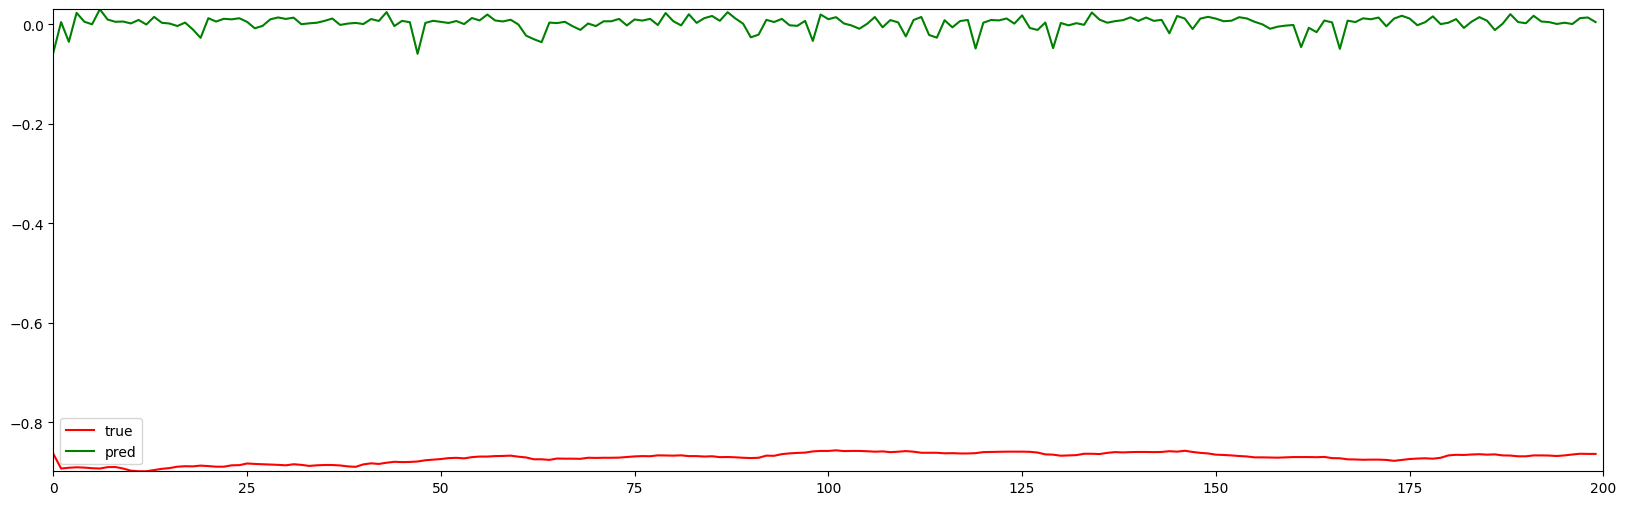

tensor([[[-0.8563, -0.8577, -0.8594, -0.8596, -0.5920],
         [-0.8595, -0.8589, -0.8585, -0.8581, -0.6277],
         [-0.8581, -0.8583, -0.8575, -0.8569, -0.6282],
         ...,
         [-0.8661, -0.8651, -0.8667, -0.8638, -0.6423],
         [-0.8637, -0.8627, -0.8627, -0.8632, -0.5896],
         [-0.8631, -0.8636, -0.8627, -0.8632, -0.6508]],

        [[-0.8751, -0.8751, -0.8743, -0.8740, -0.5469],
         [-0.8739, -0.8751, -0.8746, -0.8743, -0.6262],
         [-0.8739, -0.8727, -0.8731, -0.8716, -0.4586],
         ...,
         [-0.8900, -0.8910, -0.8907, -0.8910, -0.5780],
         [-0.8910, -0.8913, -0.8907, -0.8914, -0.6498],
         [-0.8925, -0.8934, -0.8945, -0.8947, -0.5716]],

        [[-0.8724, -0.8736, -0.8746, -0.8755, -0.5605],
         [-0.8751, -0.8751, -0.8743, -0.8740, -0.5469],
         [-0.8739, -0.8751, -0.8746, -0.8743, -0.6262],
         ...,
         [-0.8907, -0.8897, -0.8901, -0.8901, -0.6078],
         [-0.8900, -0.8910, -0.8907, -0.8910, -0.5780],
  

In [ ]:
plot_lines(test_labels[:,-1,0].flatten().cpu(),preds[:,-1,0].flatten().cpu())
test_labels